In [1]:
# fundamental package for data storage and scientific computing
import numpy as np
# package for numerical integration
import scipy.integrate as integrate
# combinatorial number
from scipy.special import comb

In [2]:
# package for drawing figures
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.ticker import MultipleLocator
plt.style.use('default')
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'svg'

In [3]:
# machine precision
prec = np.finfo(float).eps
prec

2.220446049250313e-16

# The Integration Process

Suppose we want to integrate $f(x) = \sqrt{1 - x^2}$ from $x = -1/2$ to $x = 1$. We have deliberately chosen a function which is always non-negative on the integration range to avoid complications.

In [4]:
# function to be graphed
def func(x):
    return np.sqrt(1 - x**2)
# integration limits
a, b = -1/2, 1

Let us first see the correct answer with scipy:

In [5]:
# returns integration result and estimated error
ans, err = integrate.quad(func, a, b)
ans, err

(1.2637039021427077, 2.435300849867872e-10)

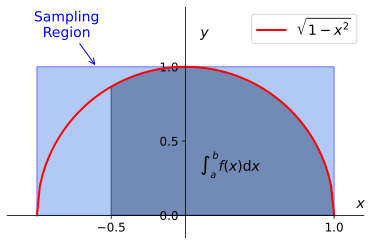

In [6]:
# x coordinates to be drawn (from -1 to 2.5, 100 points)
x = np.linspace(-1, 1, 100)
# y coordinates to be draw
y = func(x)

# create canvas for drawing
fig, ax = plt.subplots()

# adjust coordinate axes to make figure beautiful
ax.set_ylim(bottom=-0.15, top=1.4)
ax.set_xlim(left=-1.2, right=1.2)
ax.set_aspect(1)

# axes go through origin
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
# turn off unnecessary axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_xticks((a, b))
# ax.set_xticklabels(('$a$', '$b$'), fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# plot the function
ax.plot(x, y, 'r', linewidth=2, label=r'$\sqrt{1-x^2}$')
# show legend
ax.legend(loc='upper right', fontsize=14)

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.5', edgecolor='0')
# add the shaded region to the figure
ax.add_artist(poly)

# the sampling region
fa, fb = func(a), func(b)
samppoly = Rectangle((-1,0), 2, 1, facecolor='cornflowerblue', edgecolor='blue', alpha=0.5)
ax.add_artist(samppoly)

# text annotation
ax.text(0.3, 0.3, r"$\int_a^b f(x)\mathrm{d}x$",
        horizontalalignment='center', fontsize=14)
ax.annotate("Sampling\nRegion", 
            xy=(-0.6, 1.0), xytext=(-0.8, 1.2),
            arrowprops=dict(arrowstyle='->', color='blue'),
            color='blue', horizontalalignment='center', fontsize=14)

ax.text(1.15, 0.05, '$x$', fontsize=14)
ax.text(0.1, 1.2, '$y$', fontsize=14)

plt.show()

We create a **sampling region** whose area is already known. The region should cover the whole area under the curve. For simplicity, we choose the blue rectangle shown in the figure, whose area $A$ is just $2 \times 1 = 2$. Then we just randomly choose a point in the rectangle, and judge whether it is in the area under the curve within the integration range $[a, b]$. 

The integration result is given by

$$
\int_a^b f(x) dx
= \frac{X}{N} \times A
$$

where

$$
\begin{align*}
    X &: \text{Number of points under the curve}
    \\
    N &: \text{Total number of sample points}
    \\
    A &: \text{Area of sampling region}
\end{align*}
$$

with the assumption that $f(x) \ge 0$ for all $x \in [a,b]$. This method of integration is usually inefficient for one-variable functions, but shows its advantage when evaluating higher dimensional integrations. 

# Estimating the Error

The process of randomly select a point and check whether it is under the curve is a sequence of $N$ **independent experiments** with only two results: the point is under the curve ("success") or not. The exact probability of success is given by

$$
p = \frac{1}{A} \int_a^b f(x) dx \approx \frac{X}{N}
$$

Therefore, the number of times of success (which is just $X$) follows the **binomial distribution**, denoted by

$$
X \sim B(N,p)
$$

From the theory of binomial distribution (which you should have learned in high school), the standard deviation of $X$ is given by

$$
\sigma(X) = \langle (X - \langle X \rangle)^2 \rangle ^ {1/2}
= \sqrt{N p (1 - p)}
$$

where the notation $\langle \, \rangle$ means taking the average value. Then the standard deviation of the integration result is 

$$
\sigma(I) = \sigma(X) \times \frac{A}{N} 
= \sqrt{\frac{p (1-p)}{N}} A
\propto \frac{1}{\sqrt{N}}
$$

Now we obtain the important result that **the error of result goes down as $1/\sqrt{N}$**. This decay of error as $N$ becomes larger happens frequently in real life experiments. When estimating the error of calculation, we can just set $p$ to the experimental result (instead of the theoretical exact value).

# Code for Monte Carlo Integration

In [7]:
def in_area(pt):
    """Judge whether the point `pt` is under the curve"""
    if a <= pt[0] <= b and 0 <= pt[1] <= func(pt[0]):
        return True
    else:
        return False

In [8]:
# number of points to be picked
n_pt = 1000
# area of the sampling region
samparea = 2
# run the sampling for 100 times to accumulate result
results, errs = [], []
n_run = 1000
for i in range(n_run):
    # randomly generate point in the rectangle
    pts_x = np.random.uniform(-1, 1 + prec, n_pt)
    pts_y = np.random.uniform(0, 1 + prec, n_pt)
    # and count how many points are in the area under the curve
    counter = 0
    # the function `zip` helps us iterate `pts_x`, `pts_y` simutaneously
    for x, y in zip(pts_x, pts_y):
        if in_area((x,y)):
            counter += 1
    # the integration result
    p = counter / n_pt
    result = p * samparea
    # error for each run
    err = np.sqrt(p * (1-p) / (n_pt)) * samparea
    # add result to result list
    results.append(result)
    errs.append(err)
# free memory used by pts_x, pts_y after calculation is done
del pts_x, pts_y 
# print average result and estimated error, and compare to answer
result = np.average(results)
err = np.average(errs)
result, err, ans

(1.2610299999999999, 0.03050957405225863, 1.2637039021427077)

# Comparison with the Exact Binomial Distribution

The random variable $X$ follows the binomial distribution; this means that the probability that $X = k$ is given by 

$$
\operatorname{Pr}(X = k) = C_N^k p^k (1-p)^{N-k}, \quad
C_N^k = \frac{N!}{k!(N-k)!}
$$

Then the probability that $X$ falls in the range $[k_1, k_2]$ is just a simple sum:

$$
\operatorname{Pr}(k_1 \le X \le k_2) = \sum_{k=k_1}^{k_2} \operatorname{Pr}(X = k)
$$

Using this probability, we can check whether our numerical experiment agrees with the binomial distribution. The expected count that $X$ falls in the range $[k_1, k_2]$ is just 

$$
N \times \operatorname{Pr}(k_1 \le X \le k_2)
$$

which can further be converted to the count that the integration result falls in the range

$$
\left[
    \frac{k_1}{N} A, \, \frac{k_2}{N} A
\right]
$$

In [9]:
# exact value of p
p_exact = ans / samparea
p_exact

0.6318519510713538

In [10]:
def pr_binom(k):
    """Calculate the binomial probability Pr(X = k)"""
    return comb(n_run, k) * p_exact**k * (1-p_exact)**(n_run-k)

In [11]:
n_bins = 15
bins = np.linspace(result-3*err, result+3*err, n_bins+1)
counts = []
means = []
# calculate the prediction of binomial distribution
for i in range(len(bins) - 1):
    means.append(np.average(bins[i:i+2]))
    # convert integration result to value of X
    k1 = bins[i] * n_pt / samparea
    k2 = bins[i+1] * n_pt / samparea
    prob = np.sum([pr_binom(k) for k in range(int(np.ceil(k1)), int(np.ceil(k2)))])
    counts.append(prob * n_pt)

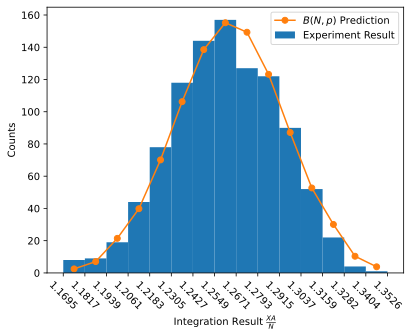

In [12]:
# visualize the distribution of integration result
fig2, ax2 = plt.subplots()
# experiment result
ax2.hist(results, bins=n_bins, range=(min(bins), max(bins)), label='Experiment Result')
# binomial distribution prediction
ax2.plot(means, counts, marker='.', markersize=12, label=r'$B(N,p)$ Prediction')
ax2.set_xticks(bins)
plt.xticks(rotation=-45)
ax2.set_xlabel(r'Integration Result $\frac{XA}{N}$')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')